# Heatmap
Heatmap of terms over time for Euroleaks and Communiques.

In [1]:
import re
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

## stopwords

In [2]:
import json

with open('../data/euroleaks/amend_names.json', 'r') as f:
    amend_names = json.load(f)
    
# make stopwords out of names
stopnames = []

for names in amend_names.values():
    for name in names:
        if not re.search('\[.*\]', name):
            stopnames += name.split(' ')
            
for name in pd.read_csv('../data/euroleaks/cleaned.csv').speaker.unique():
    if 'speaker' not in name:
        stopnames += name.split(' ')
    
stopnames = set(stopnames)

context_stopwords = [
    'erm', # synonym for hmm in https://euroleaks.diem25.org/leaks/mar17ewg/
    'today',
    'tomorrow',
    'yesterday',
    'day',
    'week',
    'month'
]

## collocations

In [3]:
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

## spacy

In [4]:
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

#filter_POS = {'NOUN'}
filter_POS = {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\

def token_filter(token):
    return token.pos_ in filter_POS\
            and not token.is_stop\
            and not token.text in stopnames\
            and not token.text in context_stopwords\
            and len(token.text) > 1 # for punctuation (but also 'I')

## Communiques

In [5]:
communiques = pd.read_csv('../data/communiques/cleaned.csv')

# group by date
communiques_groupby_date = communiques.drop(columns=['title']).groupby('date').apply(lambda s: ' '.join(s.story))

# preprocess
communique_documents = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if token_filter(token)
    ])
    for doc in communiques_groupby_date.values
]

# apply collocations
communique_bigram_colloc = {
    ('euro', 'area'),
    ('greek', 'authority'),
    ('greek', 'government'),
    ('brussel', 'group'),
    ('member', 'state'),
    ('monetary', 'union'),
    ('press', 'conference'),
    ('structural', 'reform'),
}
communique_documents = pd.Series(communique_documents).apply(lambda s: 
                apply_bigram_colloc(s,communique_bigram_colloc))

# get labels
communique_dates = communiques_groupby_date.index.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

# tfidf
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

communique_X = tfidf_vectorizer.fit_transform(communique_documents)

# get most prominent words
first_k = 20
tfidf = communique_X.sum(axis =0).A1
sort_ix = np.argsort(tfidf)[::-1]
communique_most_prominent_words = np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:first_k]
for word in np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:first_k]:
    print(word)

institution
authority
proposal
program
talk
measure
greece
agreement
work
current
inform
situation
reform
agree
financial
discuss
state
play
government
conclusion


## Euroleaks

In [6]:
leaks = pd.read_csv('../data/euroleaks/cleaned.csv')

# group by date
leaks_groupby_date = leaks.drop(columns=['timestamp','speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

# preprocess
leaks_documents = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if token_filter(token)
    ])
    for doc in leaks_groupby_date.values 
]

# apply collocations
leaks_trigram_colloc = {('euro', 'working', 'group')}
leaks_bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}
leaks_documents = pd.Series(leaks_documents).apply(lambda s: 
                apply_bigram_colloc(
                    apply_trigram_colloc(s, leaks_trigram_colloc),
                    leaks_bigram_colloc)
                                      )
# get labels
leaks_dates = leaks_groupby_date.index.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

# tfidf
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

leaks_X = tfidf_vectorizer.fit_transform(leaks_documents)

# get most prominent words
first_k = 20
tfidf = leaks_X.sum(axis =0).A1
sort_ix = np.argsort(tfidf)[::-1]
leaks_most_prominent_words = np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:first_k]
for word in np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:first_k]:
    print(word)

agreement
program
process
reform
ask
referendum
letter
eurogroup
list
people
new
like
change
liquidity
review
pension
document
month
progress
fiscal


## combined

In [7]:
documents = pd.concat((leaks_documents, communique_documents))
dates = pd.concat((leaks_dates, communique_dates)).values

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.99, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

X = tfidf_vectorizer.fit_transform(documents)
print(X.shape)

(25, 3544)


In [8]:
'authority' in tfidf_vectorizer.get_feature_names()

True

In [9]:
most_prominent_words = np.sort(np.unique(np.concatenate((leaks_most_prominent_words, communique_most_prominent_words))))

print(len(most_prominent_words), '\n')
for w in most_prominent_words:
    print(w)

37 

agree
agreement
ask
authority
change
conclusion
current
discuss
document
eurogroup
financial
fiscal
government
greece
inform
institution
letter
like
liquidity
list
measure
month
new
pension
people
play
process
program
progress
proposal
referendum
reform
review
situation
state
talk
work


In [23]:
my_keywords = [
    
    # prominent in both
    'agreement',
    'referendum',
    'letter',
    'political',
    'ecb',
    'imf',
    'esm',
    'market',
    'mou',
    'institution',
    'greece',
    
    # prominent in leaks but not communiques
    'aide_memoire',
    'brussel_group',
    'capital_control',
    'collective_bargaining',
    'labor_market',
    'liquidity',
    'minimum_wage',
    'pension',
    'second_letter',
    'smp_bond',
    'tax',
    'interest_rate',
    'parliament',
    'primary_surplus',
    'maximum_flexibility',
    
    
    # prominent in communiques but not leaks
    'structural_reform',
    
    
    
    #'20th_february',
    #'process',
    #'reform',
    #'program',
    #'progress',
    #'policy',
    #'people',
    #'change',
    #'prime_minister',
    #'bank',
    #'debt',
    #'deficit'
    #'budget',
    #'labor',
    #'anti_corruption',
    #'debt_sustainability',
    #'growth',
    #'growth_friendly',
    #'flexibility',
    #'real_estate', 
    #'unemployment',
    #'health',
    #'wage'
]

my_keywords = np.sort(np.unique(my_keywords))

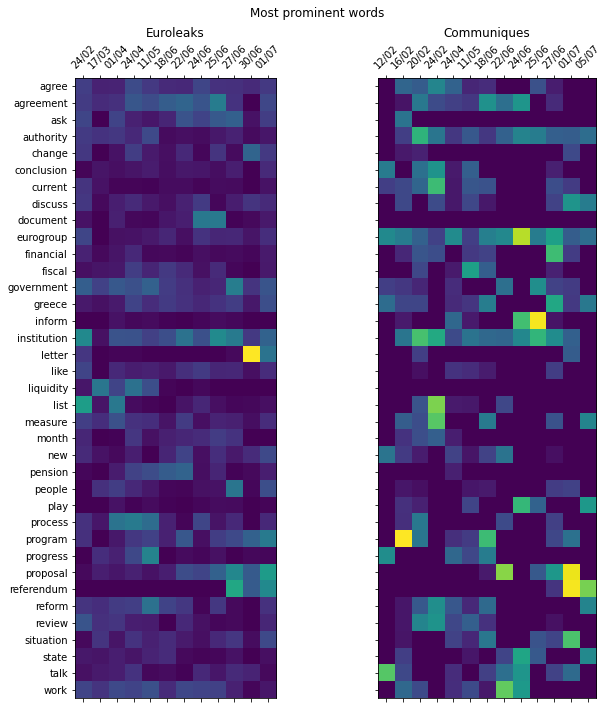

In [24]:
keywords = most_prominent_words

fig, axes = plt.subplots(1,2,figsize=(10,10),sharey=True)

# leaks
axes[0].matshow(X.toarray()[:len(leaks_dates)][:,[tfidf_vectorizer.get_feature_names().index(word) for word in keywords]].T)
axes[0].set_xticks(range(len(leaks_dates)))
_ = axes[0].set_xticklabels(leaks_dates, rotation=45)

# communiques
axes[1].matshow(X.toarray()[len(leaks_dates):][:,[tfidf_vectorizer.get_feature_names().index(word) for word in keywords]].T)
axes[1].set_xticks(range(len(communique_dates)))
_ = axes[1].set_xticklabels(communique_dates, rotation=45)

# shared y axis
axes[0].set_yticks(range(len(keywords)))
_ = axes[0].set_yticklabels(keywords)
#axes[1].set_yticks(range(len(keywords)))
#_ = axes[1].set_yticklabels(keywords)

axes[0].set_title('Euroleaks')
axes[1].set_title('Communiques')

fig.suptitle('Most prominent words')

fig.tight_layout()

Grid: https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow

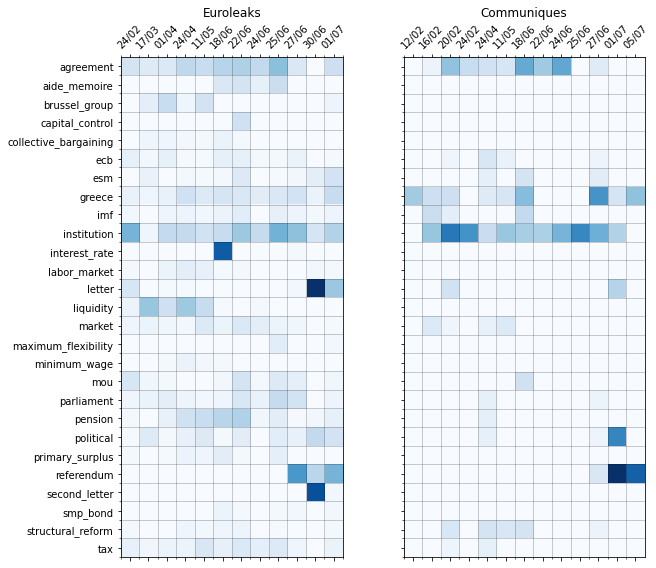

In [41]:
keywords = my_keywords

fig, axes = plt.subplots(1,2,figsize=(10,8),sharey=True)

# leaks
axes[0].matshow(X.toarray()[:len(leaks_dates)][:,[tfidf_vectorizer.get_feature_names().index(word) for word in keywords]].T,
                cmap='Blues')
axes[0].set_xticks(np.arange(len(leaks_dates)))
_ = axes[0].set_xticklabels(leaks_dates, rotation=45)
# grids
axes[0].set_xticks(np.arange(-.5, len(leaks_dates), 1), minor=True)
axes[0].set_yticks(np.arange(len(keywords)))
axes[0].set_yticks(np.arange(-.53, len(keywords), 1), minor=True)
axes[0].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# communiques
axes[1].matshow(X.toarray()[len(leaks_dates):][:,[tfidf_vectorizer.get_feature_names().index(word) for word in keywords]].T,
                cmap='Blues')
axes[1].set_xticks(range(len(communique_dates)))
_ = axes[1].set_xticklabels(communique_dates, rotation=45)
# grids
axes[1].set_xticks(np.arange(-.5, len(leaks_dates), 1), minor=True)
axes[1].set_yticks(np.arange(len(keywords)))
axes[1].set_yticks(np.arange(-.53, len(keywords), 1), minor=True)
axes[1].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# shared y axis
axes[0].set_yticks(range(len(keywords)))
_ = axes[0].set_yticklabels(keywords)
#axes[1].set_yticks(range(len(keywords)))
#_ = axes[1].set_yticklabels(keywords)

axes[0].set_title('Euroleaks')
axes[1].set_title('Communiques')

#fig.suptitle('Keywords')

fig.tight_layout()

fig.savefig('../figures/term_heatmap.png')